# **Bibliotecas e Funções**

In [ ]:
%%capture

!pip install shap
!pip install optuna
!pip install cmaes

In [ ]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [ ]:
!pip install gdown==4.6.0
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [ ]:
%%capture

!gdown 129xV7F8XXr_4PqRtcR-GV7unEgNrL6qW --quiet # Sistema Digestório treino
!gdown 13aJGpxw_tAhT-44yuD-mRKjDsJcHwynU --quiet # Sistema Digestório teste

In [ ]:
df_sist_dig_treino = pd.read_csv('/content/sist_dig_treino.csv')
print(df_sist_dig_treino.shape)
df_sist_dig_treino.head(3)

(95757, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.855039,-0.487127,0.754328,1.139443,-0.941420,0.659026,-0.310484,0.947846,0.941740,1.192445,...,0.030938,1.236514,0.910933,0.435937,0.471588,0.499958,-0.880861,-0.472869,Boca,0
1,-0.552332,-0.974444,0.882521,-0.739385,-1.035237,1.050825,-0.220933,0.600390,-0.571222,0.737469,...,0.408728,-0.942713,-0.767966,0.798171,0.395082,-0.817516,0.969004,-0.476098,Colorretal,0
2,-1.031751,2.898275,-0.940926,-0.673702,-0.992019,0.061359,-0.373475,-0.522447,0.778654,0.774996,...,0.907689,-0.839215,-1.543551,0.726838,0.741448,0.530647,-1.028309,-0.437315,Orofaringe,0


In [ ]:
df_sist_dig_teste = pd.read_csv('/content/sist_dig_teste.csv')
print(df_sist_dig_teste.shape)
df_sist_dig_teste.head(3)

(31922, 27)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,NENHUM,CIRURGIA,RADIO,QUIMIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,-0.552332,-0.974444,-0.003123,-0.739385,-1.035237,-0.877917,-0.220933,0.600390,-0.571222,-1.355989,...,-0.747934,1.575075,0.652640,0.769895,-0.964587,-0.817516,-1.031988,-0.476098,Colorretal,1
1,-0.651186,-0.487127,-0.937624,1.139443,1.062225,-0.300085,-0.310484,-1.055024,0.941740,1.192445,...,-0.512219,1.963232,1.866126,-0.975263,-1.245632,-0.632483,1.135253,-0.472869,Boca,0
2,1.583661,-0.974444,0.882521,-1.030502,-1.035237,-0.877917,-0.220933,0.600390,-0.571222,-1.355989,...,0.023174,-0.942713,-0.767966,0.798171,4.474089,-0.817516,0.969004,-0.476098,Colorretal,0


In [ ]:
um = ['Esôfago', 'Estômago', 'Colorretal']
dois = ['Delgado', 'Estômago', 'Colorretal']

df1_treino = df_sist_dig_treino[df_sist_dig_treino.TOPOGRUP.isin(um)]
df1_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP.isin(um)]

df2_treino = df_sist_dig_treino[df_sist_dig_treino.TOPOGRUP.isin(dois)]
df2_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP.isin(dois)]

df1_treino.shape, df1_teste.shape, df2_treino.shape, df2_teste.shape

((71612, 27), (23872, 27), (62439, 27), (20814, 27))

In [ ]:
# DFs de teste para cada tipo
# boca_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Boca']
# oro_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Orofaringe']
eso_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Esôfago']
esto_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Estômago']
delg_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Delgado']
colo_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Colorretal']
# anus_teste = df_sist_dig_teste[df_sist_dig_teste.TOPOGRUP == 'Ânus']

# boca_teste.shape, oro_teste.shape,
eso_teste.shape, esto_teste.shape, delg_teste.shape, colo_teste.shape,
# anus_teste.shape

((3447, 27), (6837, 27), (389, 27), (13588, 27))

# **Sistema Digestório Juntos**

Esôfago, Estômago e Colorretal

## **Pré-processamento**

In [ ]:
topo = ['Colorretal', 'Esôfago', 'Estômago']
num = [0, 1, 2]

df1_treino.TOPOGRUP.replace(topo, num, inplace=True)
df1_teste.TOPOGRUP.replace(topo, num, inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
df1_treino['TOPOGRUP'] = ss.fit_transform(df1_treino[['TOPOGRUP']])
df1_teste['TOPOGRUP'] = ss.transform(df1_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df1_treino.drop(columns=list_drop).copy()
y_train = df1_treino.sobrevida_3anos.copy()

# Teste
X_test = df1_teste.drop(columns=list_drop).copy()
y_test = df1_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((71612, 26), (71612,), (23872, 26), (23872,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'NENHUM',
       'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS',
       'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS',
       'IBGEATEN', 'HABILIT2', 'ESCOLARI_preench', 'IBGE_idem_IBGEATEN',
       'presenca_rec', 'TOPOGRUP'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

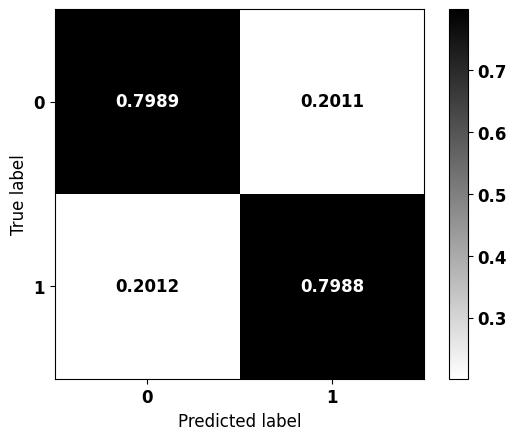


              precision    recall  f1-score   support

           0     0.8534    0.7989    0.8252     14192
           1     0.7304    0.7988    0.7631      9680

    accuracy                         0.7988     23872
   macro avg     0.7919    0.7988    0.7941     23872
weighted avg     0.8035    0.7988    0.8000     23872



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=1.241,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

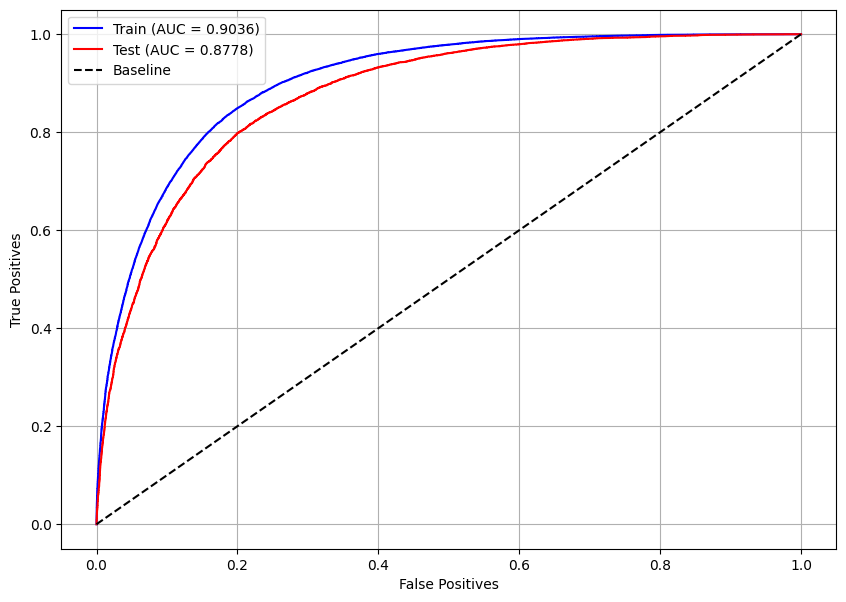

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

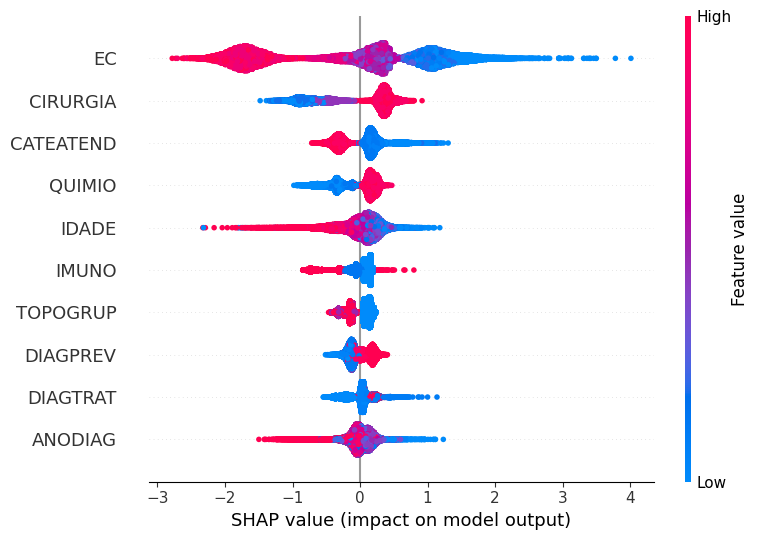

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 141,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.22, 1.25, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

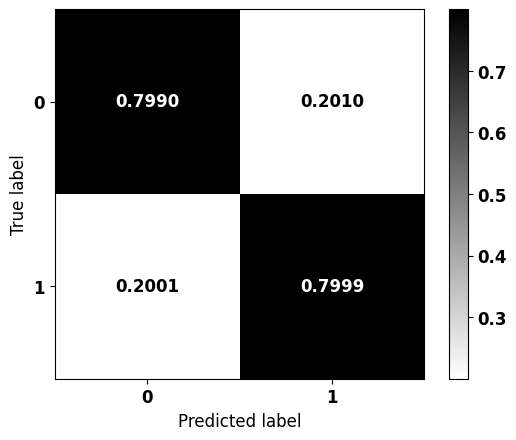


              precision    recall  f1-score   support

           0     0.8541    0.7990    0.8257     14192
           1     0.7308    0.7999    0.7638      9680

    accuracy                         0.7994     23872
   macro avg     0.7925    0.7995    0.7947     23872
weighted avg     0.8041    0.7994    0.8006     23872



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.246

xgb_random = XGBClassifier()
xgb_random.set_params(**params)

xgb_random.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_random, X_test, y_test)

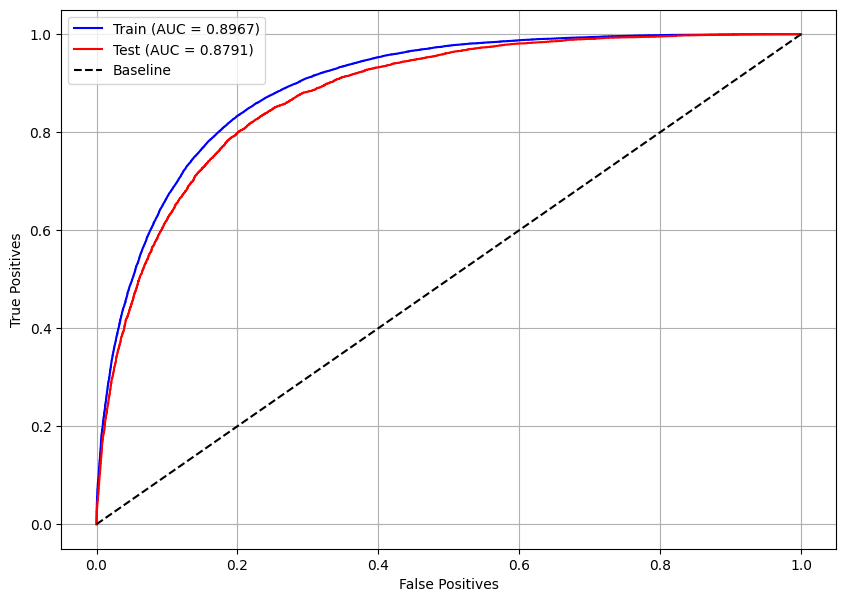

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_random, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 133,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'min_child_weight': 3,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(1.22, 1.25, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

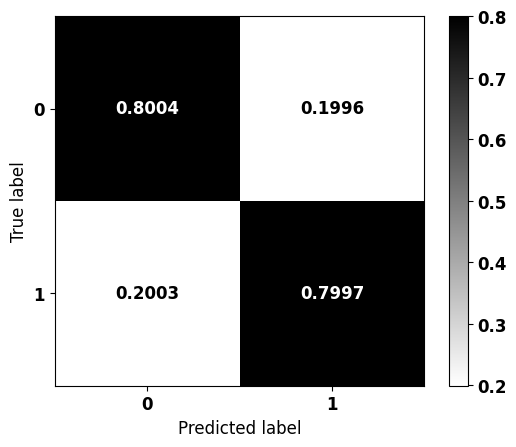


              precision    recall  f1-score   support

           0     0.8542    0.8004    0.8264     14192
           1     0.7321    0.7997    0.7644      9680

    accuracy                         0.8001     23872
   macro avg     0.7931    0.8000    0.7954     23872
weighted avg     0.8047    0.8001    0.8013     23872



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.224

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

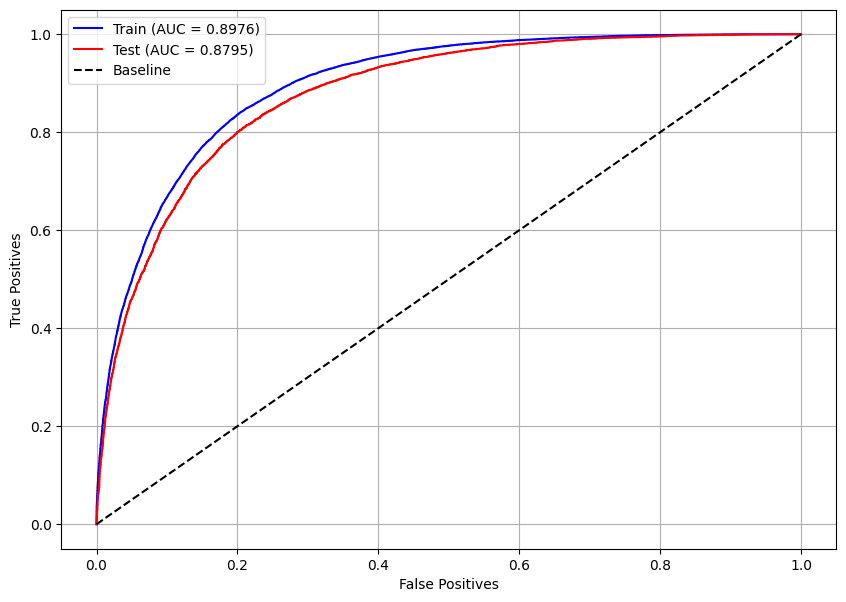

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 135,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 4,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(1.22, 1.25, 0.001), 3)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

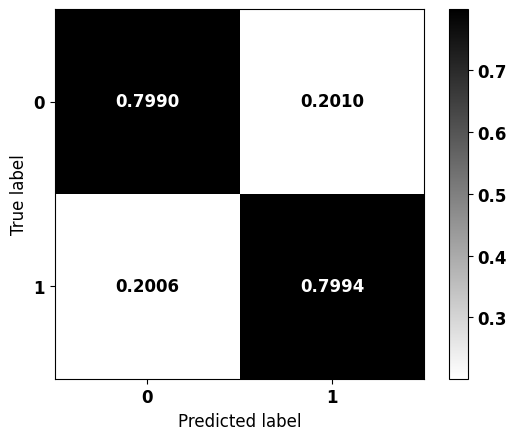


              precision    recall  f1-score   support

           0     0.8538    0.7990    0.8255     14192
           1     0.7307    0.7994    0.7635      9680

    accuracy                         0.7992     23872
   macro avg     0.7922    0.7992    0.7945     23872
weighted avg     0.8039    0.7992    0.8004     23872



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 1.246

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

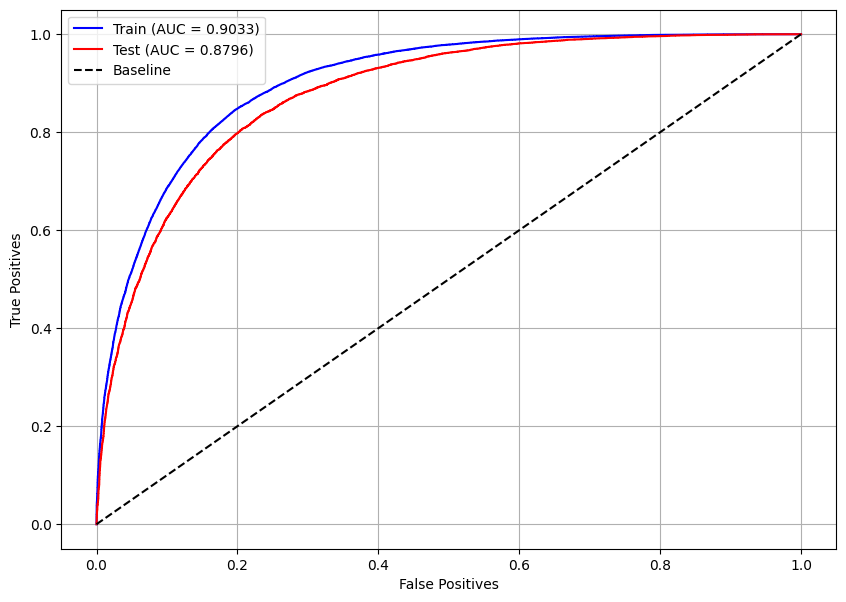

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [xgb_random, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=133, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


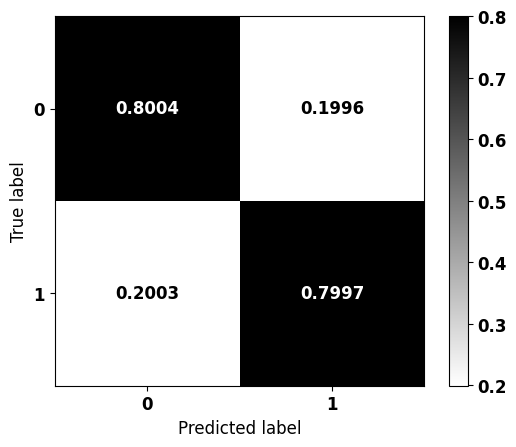


              precision    recall  f1-score   support

           0     0.8542    0.8004    0.8264     14192
           1     0.7321    0.7997    0.7644      9680

    accuracy                         0.8001     23872
   macro avg     0.7931    0.8000    0.7954     23872
weighted avg     0.8047    0.8001    0.8013     23872



In [ ]:
params = best.get_params()

# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

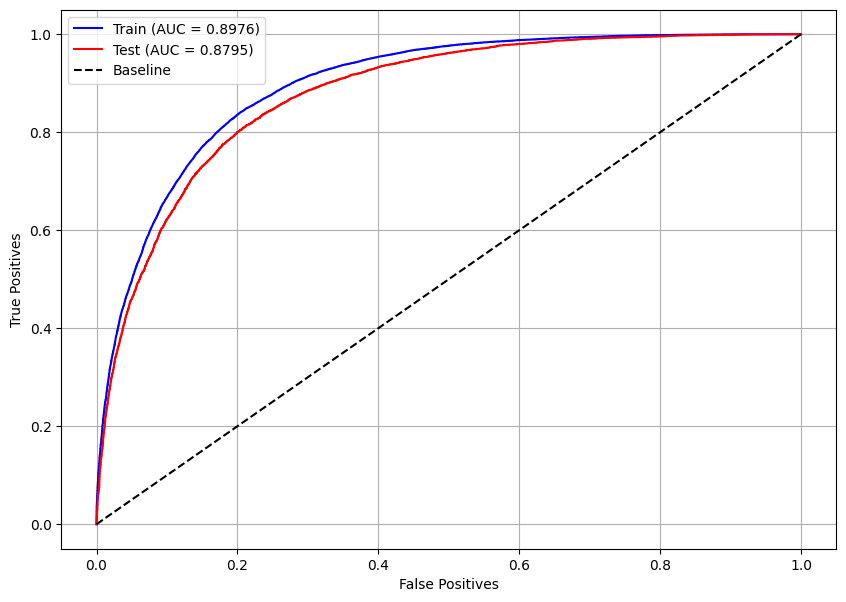

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

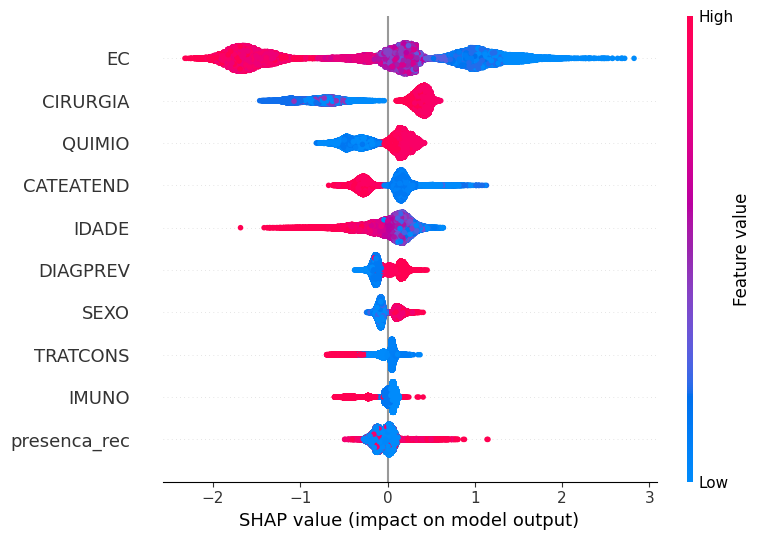

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

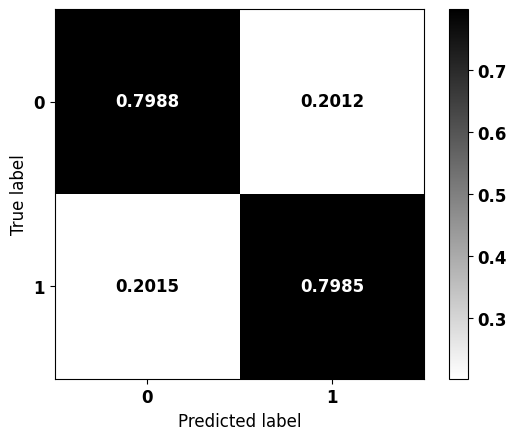


              precision    recall  f1-score   support

           0     0.8532    0.7988    0.8251     14192
           1     0.7302    0.7985    0.7628      9680

    accuracy                         0.7986     23872
   macro avg     0.7917    0.7986    0.7939     23872
weighted avg     0.8033    0.7986    0.7998     23872



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1, 1:1.224},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

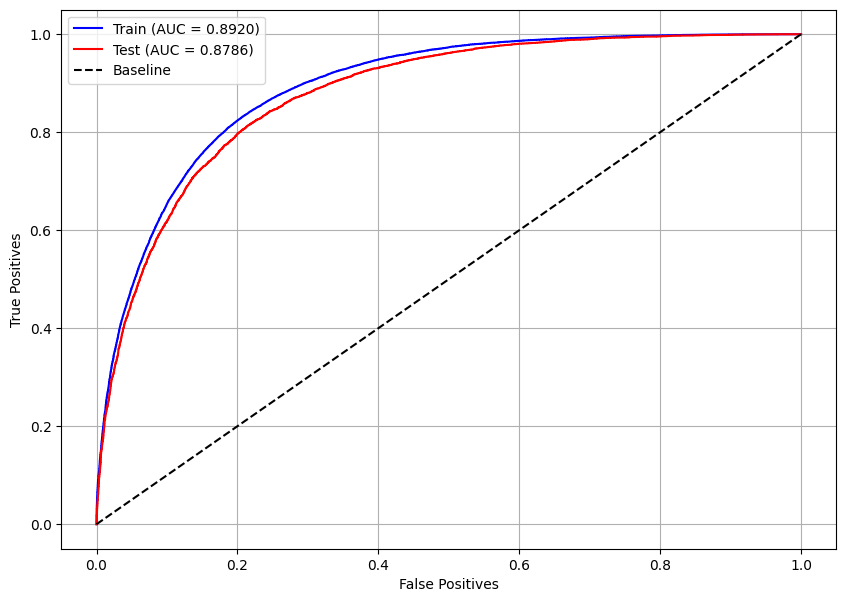

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

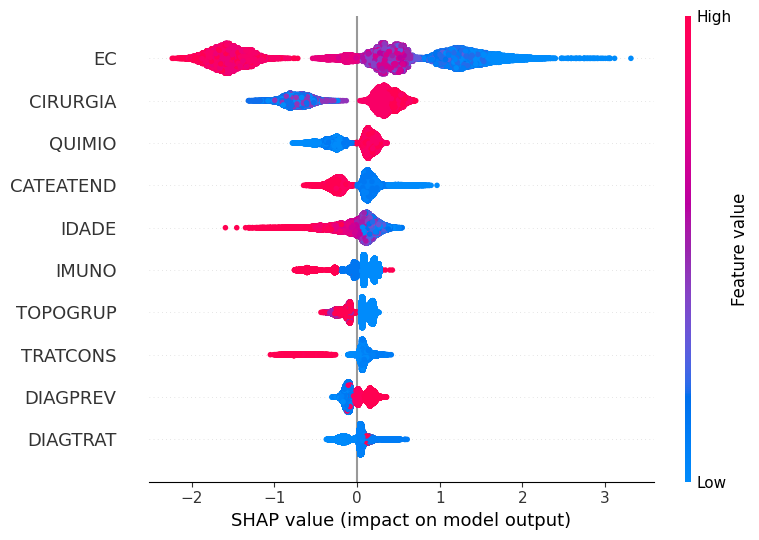

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 125,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'min_child_weight': 7,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1.23, 1.25, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

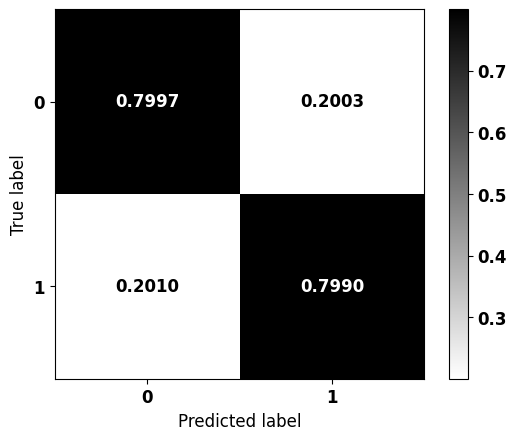


              precision    recall  f1-score   support

           0     0.8536    0.7997    0.8258     14192
           1     0.7313    0.7990    0.7636      9680

    accuracy                         0.7994     23872
   macro avg     0.7925    0.7994    0.7947     23872
weighted avg     0.8040    0.7994    0.8006     23872



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.239}

lgbm_random = LGBMClassifier(verbose=-1)
lgbm_random.set_params(**params)

lgbm_random.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_random, X_test, y_test)

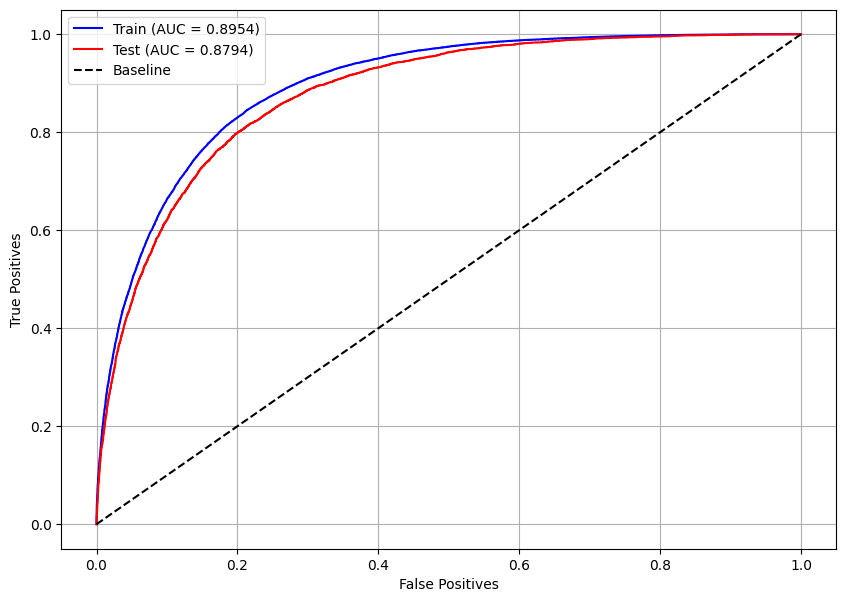

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_random, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 105,
 'max_depth': 7,
 'learning_rate': 0.19,
 'min_child_weight': 5,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(1.23, 1.25, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

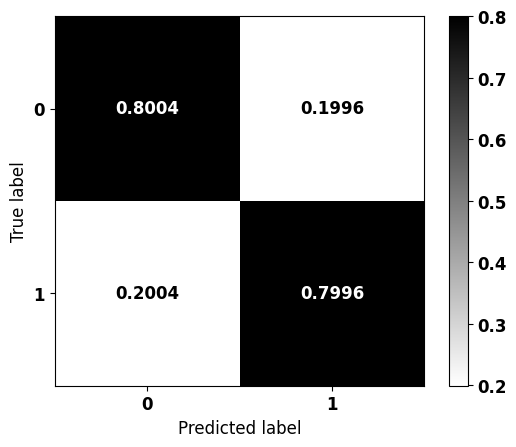


              precision    recall  f1-score   support

           0     0.8541    0.8004    0.8264     14192
           1     0.7321    0.7996    0.7643      9680

    accuracy                         0.8001     23872
   macro avg     0.7931    0.8000    0.7954     23872
weighted avg     0.8046    0.8001    0.8012     23872



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.239}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

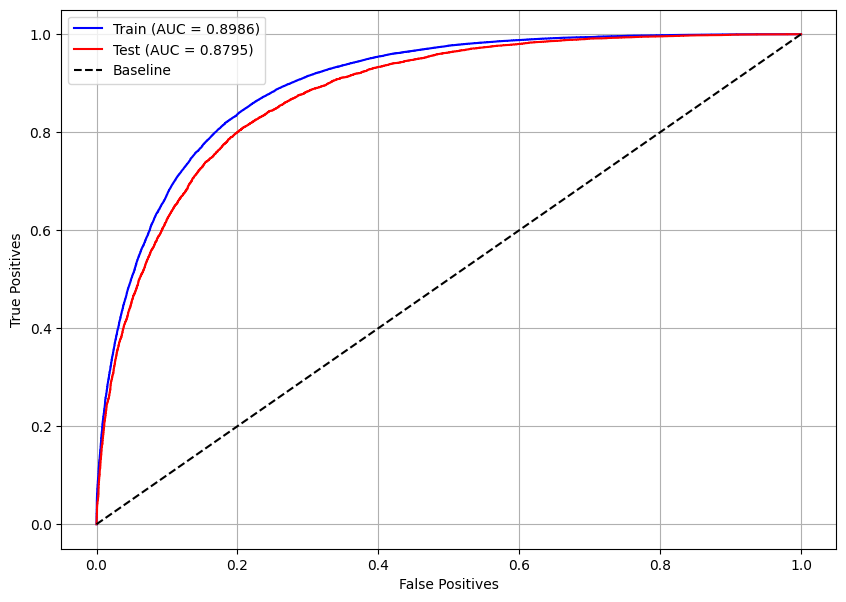

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 136,
 'max_depth': 8,
 'learning_rate': 0.16999999999999998,
 'min_child_weight': 7,
 'colsample_bytree': 0.5}

In [ ]:
pesos = np.round(np.arange(1.22, 1.26, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:1, 1:i}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

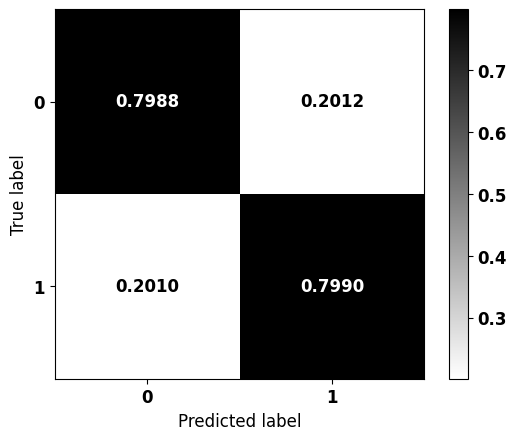


              precision    recall  f1-score   support

           0     0.8535    0.7988    0.8252     14192
           1     0.7303    0.7990    0.7631      9680

    accuracy                         0.7988     23872
   macro avg     0.7919    0.7989    0.7942     23872
weighted avg     0.8035    0.7988    0.8000     23872



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1, 1:1.257}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

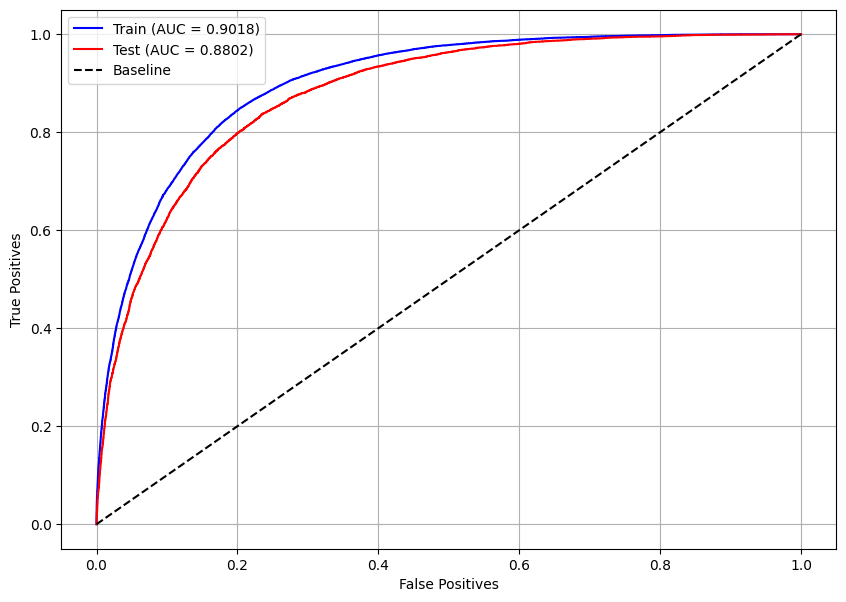

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [lgbm_random, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1, 1: 1.239}, colsample_bytree=0.5,
               learning_rate=0.19, max_depth=7, min_child_weight=5,
               n_estimators=105, random_state=7, verbose=-1)


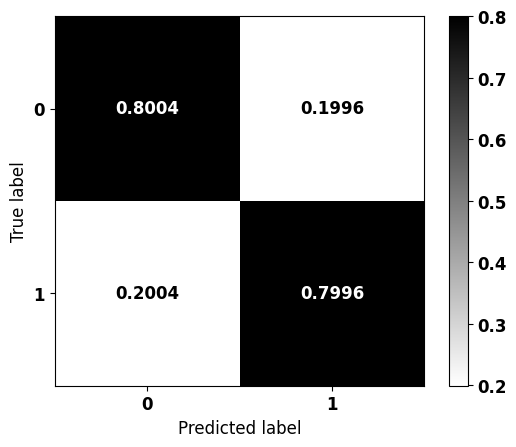


              precision    recall  f1-score   support

           0     0.8541    0.8004    0.8264     14192
           1     0.7321    0.7996    0.7643      9680

    accuracy                         0.8001     23872
   macro avg     0.7931    0.8000    0.7954     23872
weighted avg     0.8046    0.8001    0.8012     23872



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

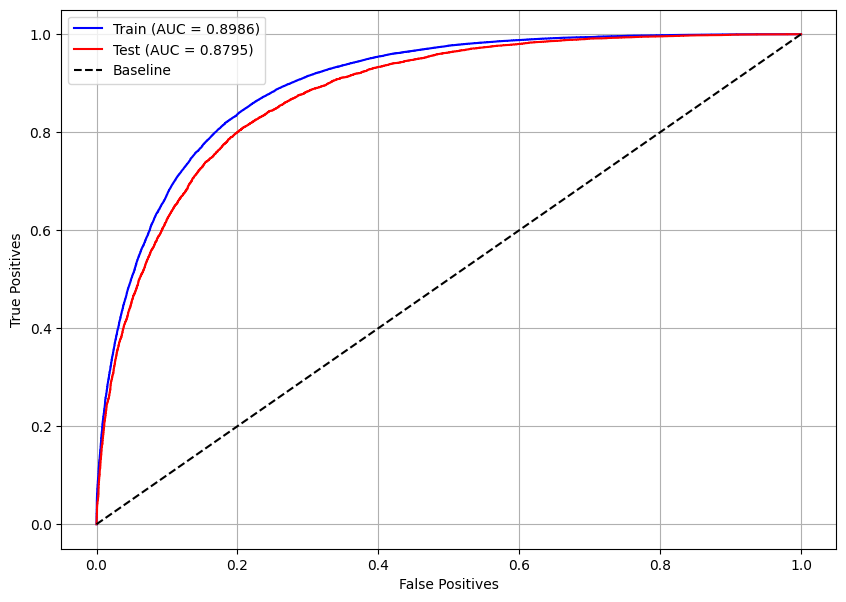

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


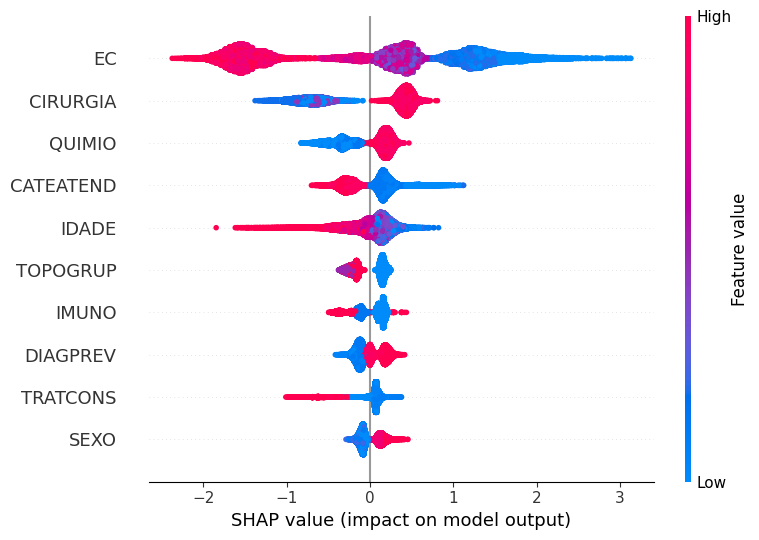

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=133, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


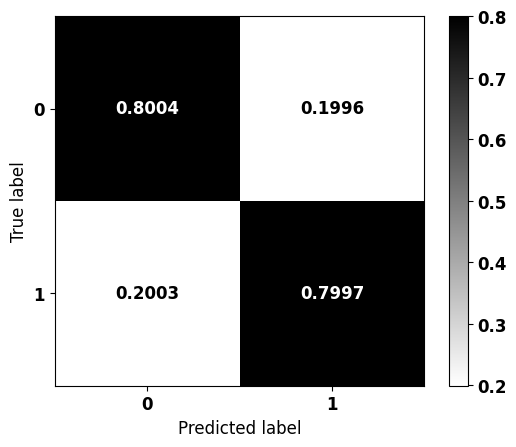


              precision    recall  f1-score   support

           0     0.8542    0.8004    0.8264     14192
           1     0.7321    0.7997    0.7644      9680

    accuracy                         0.8001     23872
   macro avg     0.7931    0.8000    0.7954     23872
weighted avg     0.8047    0.8001    0.8013     23872



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

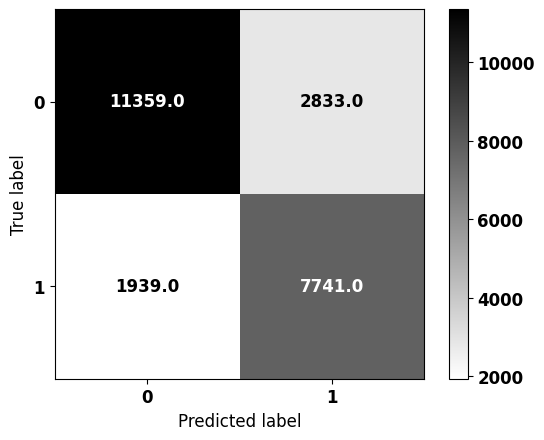


              precision    recall  f1-score   support

           0     0.8542    0.8004    0.8264     14192
           1     0.7321    0.7997    0.7644      9680

    accuracy                         0.8001     23872
   macro avg     0.7931    0.8000    0.7954     23872
weighted avg     0.8047    0.8001    0.8013     23872



In [ ]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

In [ ]:
dfs = [colo_teste, eso_teste, esto_teste]

for i, df in enumerate(dfs):
    df.TOPOGRUP.replace(df.TOPOGRUP.unique()[0], i, inplace=True)
    df['TOPOGRUP'] = ss.transform(df[['TOPOGRUP']])

In [ ]:
# Esôfago
X_test_eso = eso_teste.drop(columns=list_drop).copy()
y_test_eso = eso_teste.sobrevida_3anos.copy()

# Estômago
X_test_esto = esto_teste.drop(columns=list_drop).copy()
y_test_esto = esto_teste.sobrevida_3anos.copy()

# Colorretal
X_test_colo = colo_teste.drop(columns=list_drop).copy()
y_test_colo = colo_teste.sobrevida_3anos.copy()

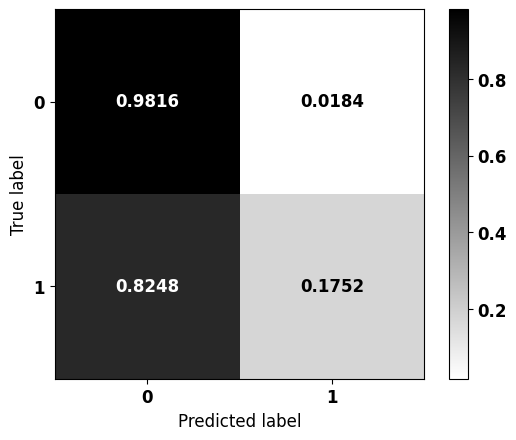


              precision    recall  f1-score   support

           0     0.8877    0.9816    0.9323      2996
           1     0.5896    0.1752    0.2701       451

    accuracy                         0.8761      3447
   macro avg     0.7386    0.5784    0.6012      3447
weighted avg     0.8487    0.8761    0.8457      3447



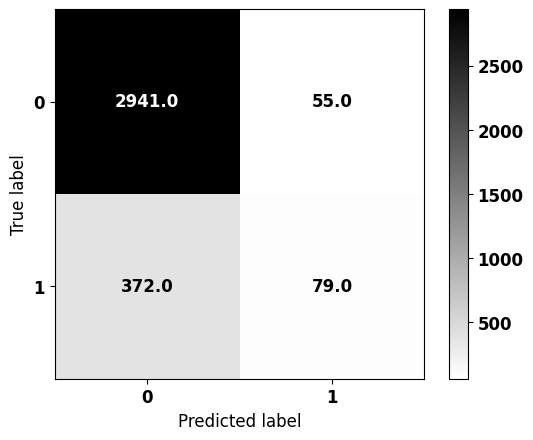


              precision    recall  f1-score   support

           0     0.8877    0.9816    0.9323      2996
           1     0.5896    0.1752    0.2701       451

    accuracy                         0.8761      3447
   macro avg     0.7386    0.5784    0.6012      3447
weighted avg     0.8487    0.8761    0.8457      3447



In [ ]:
# Esôfago
plot_confusion_matrix(best, X_test_eso, y_test_eso)
plot_confusion_matrix(best, X_test_eso, y_test_eso, norm=False)

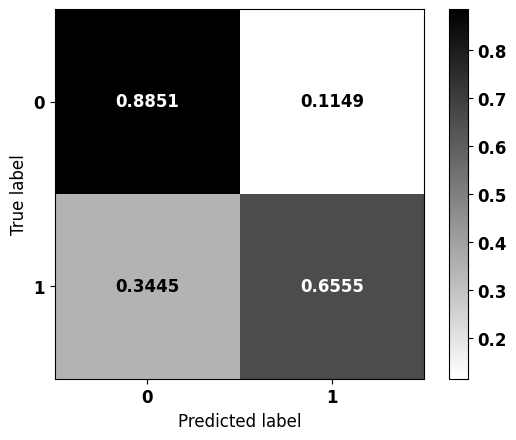


              precision    recall  f1-score   support

           0     0.8760    0.8851    0.8806      5014
           1     0.6748    0.6555    0.6650      1823

    accuracy                         0.8239      6837
   macro avg     0.7754    0.7703    0.7728      6837
weighted avg     0.8224    0.8239    0.8231      6837



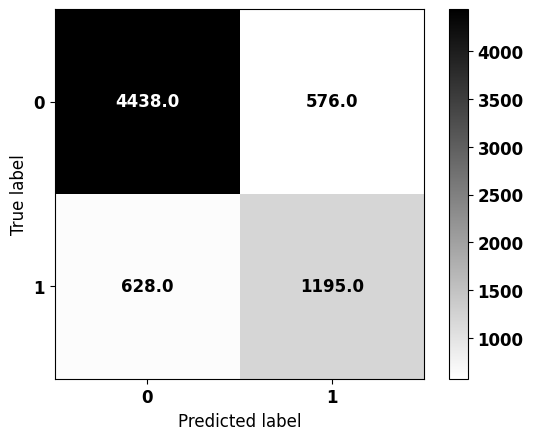


              precision    recall  f1-score   support

           0     0.8760    0.8851    0.8806      5014
           1     0.6748    0.6555    0.6650      1823

    accuracy                         0.8239      6837
   macro avg     0.7754    0.7703    0.7728      6837
weighted avg     0.8224    0.8239    0.8231      6837



In [ ]:
# Estômago
plot_confusion_matrix(best, X_test_esto, y_test_esto)
plot_confusion_matrix(best, X_test_esto, y_test_esto, norm=False)

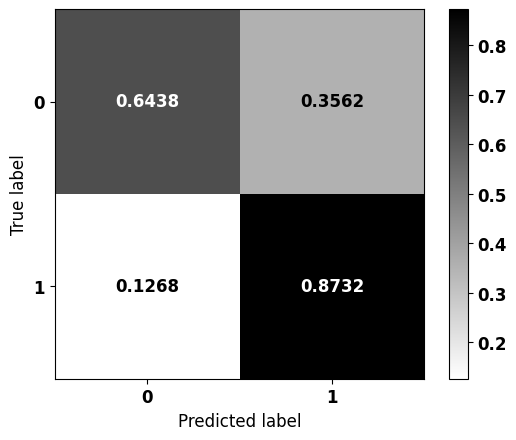


              precision    recall  f1-score   support

           0     0.8091    0.6438    0.7171      6182
           1     0.7460    0.8732    0.8046      7406

    accuracy                         0.7688     13588
   macro avg     0.7775    0.7585    0.7608     13588
weighted avg     0.7747    0.7688    0.7648     13588



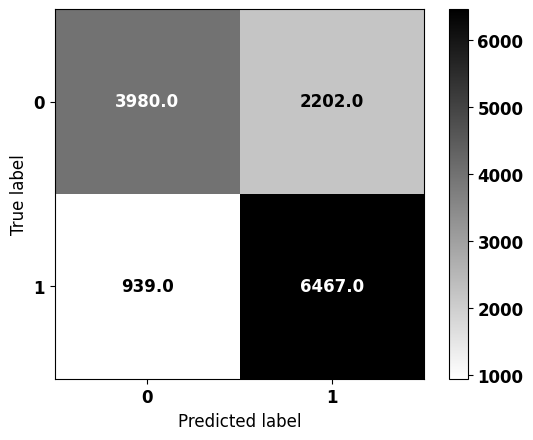


              precision    recall  f1-score   support

           0     0.8091    0.6438    0.7171      6182
           1     0.7460    0.8732    0.8046      7406

    accuracy                         0.7688     13588
   macro avg     0.7775    0.7585    0.7608     13588
weighted avg     0.7747    0.7688    0.7648     13588



In [ ]:
# Colorretal
plot_confusion_matrix(best, X_test_colo, y_test_colo)
plot_confusion_matrix(best, X_test_colo, y_test_colo, norm=False)

### **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7988, Optuna = 0.8001

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7986, Optuna = 0.8001

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1, 1: 1.239}, colsample_bytree=0.5,
               learning_rate=0.19, max_depth=7, min_child_weight=5,
               n_estimators=105, random_state=7, verbose=-1)

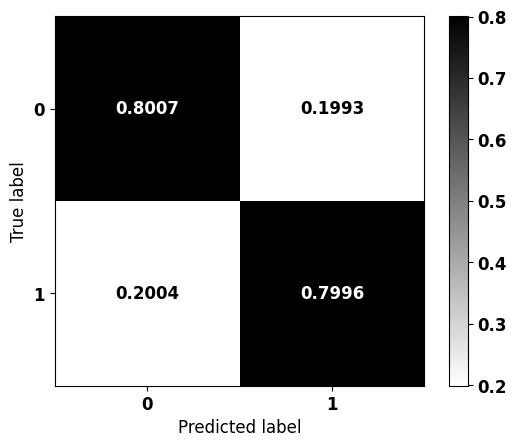


              precision    recall  f1-score   support

           0     0.8542    0.8007    0.8266     14192
           1     0.7324    0.7996    0.7645      9680

    accuracy                         0.8003     23872
   macro avg     0.7933    0.8002    0.7956     23872
weighted avg     0.8048    0.8003    0.8014     23872



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

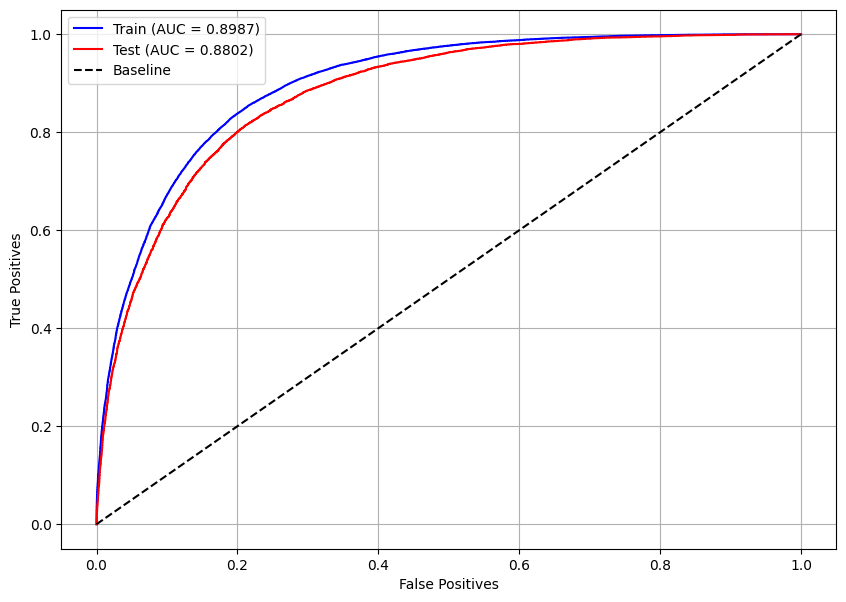

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)

# **Sistema Digestório Juntos**

Intestino Delgado, Estômago e Colorretal

## **Pré-processamento**

In [ ]:
topo = ['Colorretal', 'Delgado', 'Estômago']
num = [0, 1, 2]

df2_treino.TOPOGRUP.replace(topo, num, inplace=True)
df2_teste.TOPOGRUP.replace(topo, num, inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
df2_treino['TOPOGRUP'] = ss.fit_transform(df2_treino[['TOPOGRUP']])
df2_teste['TOPOGRUP'] = ss.transform(df2_teste[['TOPOGRUP']])

In [ ]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df2_treino.drop(columns=list_drop).copy()
y_train = df2_treino.sobrevida_3anos.copy()

# Teste
X_test = df2_teste.drop(columns=list_drop).copy()
y_test = df2_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((62439, 26), (62439,), (20814, 26), (20814,))

In [ ]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'NENHUM',
       'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS',
       'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS',
       'IBGEATEN', 'HABILIT2', 'ESCOLARI_preench', 'IBGE_idem_IBGEATEN',
       'presenca_rec', 'TOPOGRUP'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

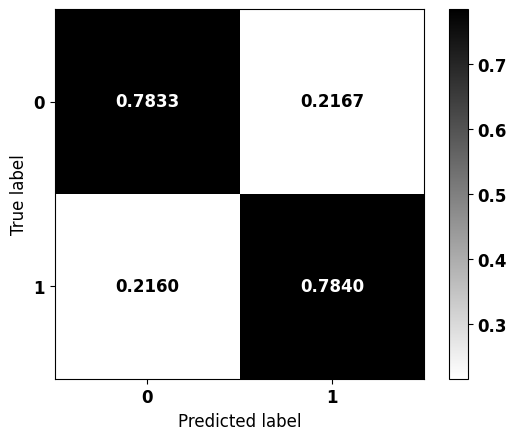


              precision    recall  f1-score   support

           0     0.8149    0.7833    0.7988     11412
           1     0.7488    0.7840    0.7660      9402

    accuracy                         0.7836     20814
   macro avg     0.7818    0.7836    0.7824     20814
weighted avg     0.7850    0.7836    0.7840     20814



In [ ]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=5,
                    scale_pos_weight=0.986,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

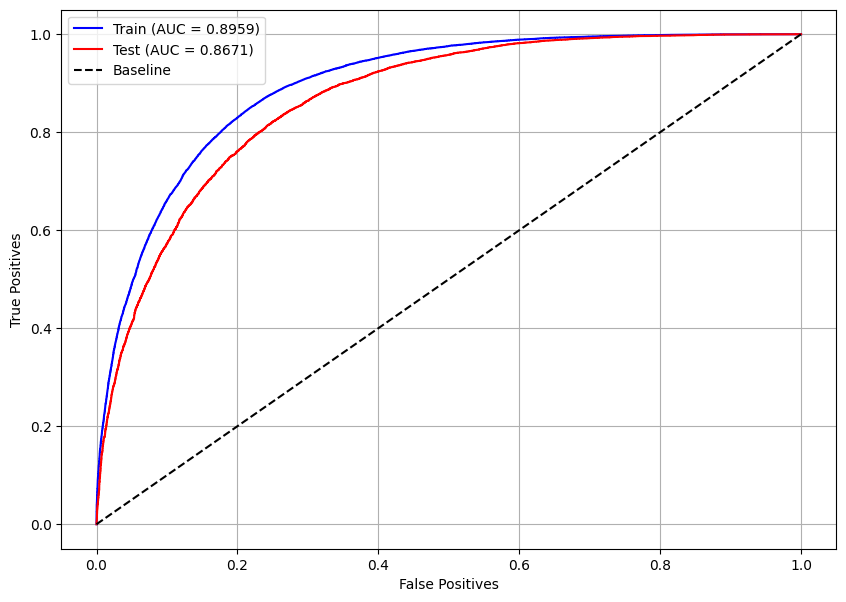

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

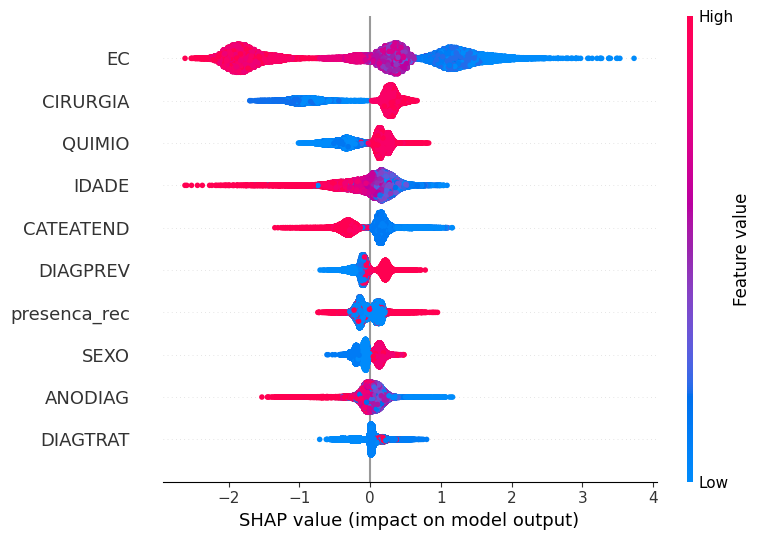

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 147,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.3,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.975, 0.99, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

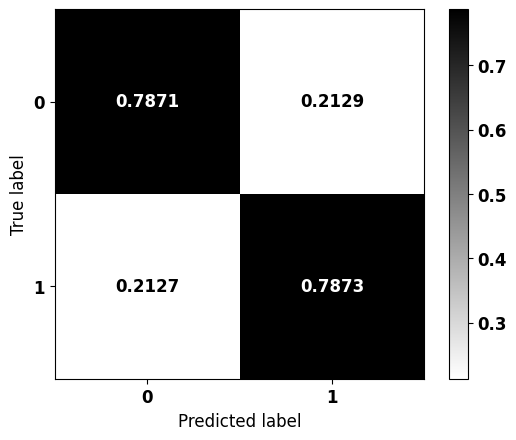


              precision    recall  f1-score   support

           0     0.8179    0.7871    0.8022     11412
           1     0.7528    0.7873    0.7697      9402

    accuracy                         0.7872     20814
   macro avg     0.7854    0.7872    0.7859     20814
weighted avg     0.7885    0.7872    0.7875     20814



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.981

xgb_random = XGBClassifier()
xgb_random.set_params(**params)

xgb_random.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_random, X_test, y_test)

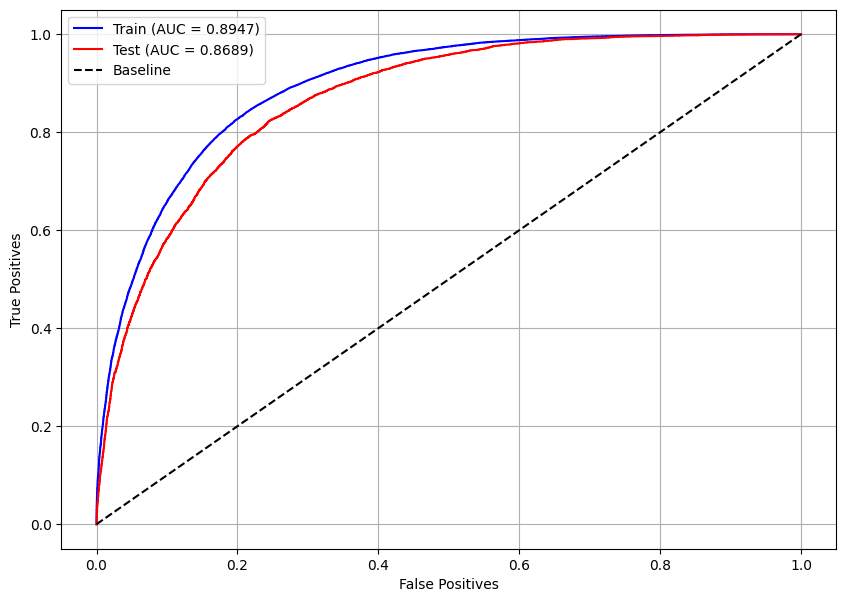

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_random, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 114,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.3,
 'min_child_weight': 4,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.975, 0.99, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

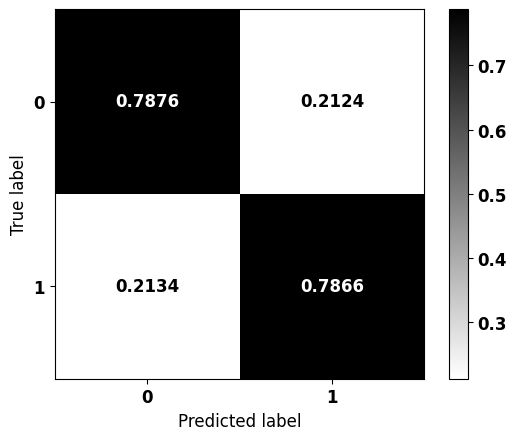


              precision    recall  f1-score   support

           0     0.8175    0.7876    0.8023     11412
           1     0.7532    0.7866    0.7695      9402

    accuracy                         0.7872     20814
   macro avg     0.7853    0.7871    0.7859     20814
weighted avg     0.7885    0.7872    0.7875     20814



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.9804

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

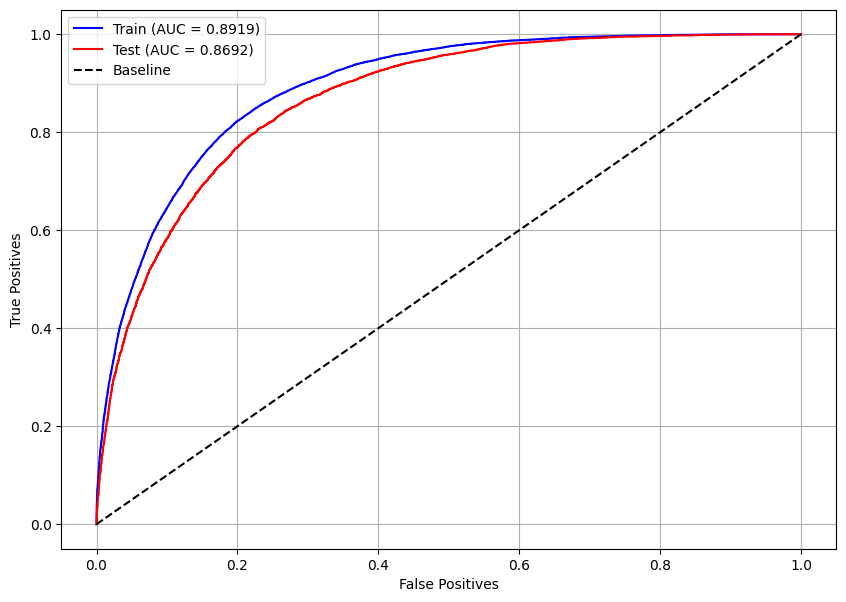

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 132,
 'max_depth': 6,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.1,
 'min_child_weight': 4,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.975, 0.99, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

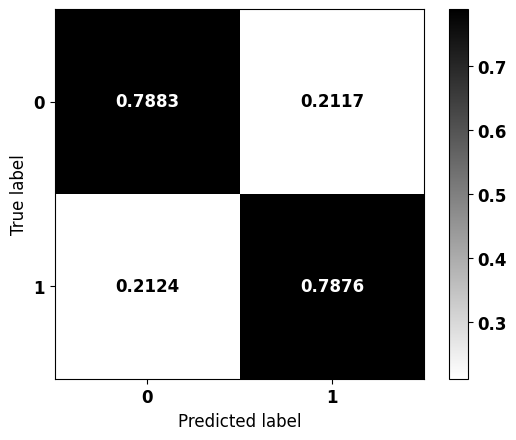


              precision    recall  f1-score   support

           0     0.8183    0.7883    0.8030     11412
           1     0.7540    0.7876    0.7704      9402

    accuracy                         0.7880     20814
   macro avg     0.7862    0.7879    0.7867     20814
weighted avg     0.7893    0.7880    0.7883     20814



In [ ]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.9888

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

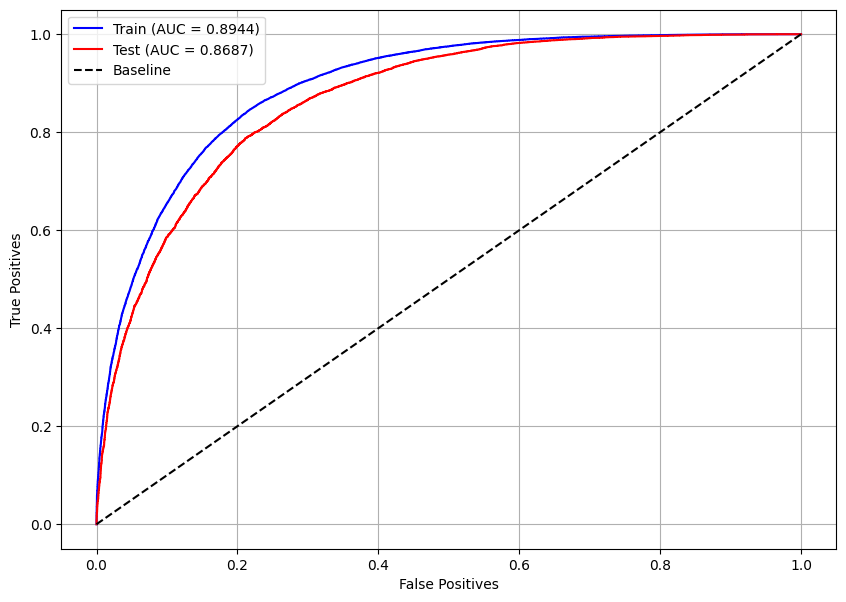

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [xgb_random, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15000000000000002,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=132, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


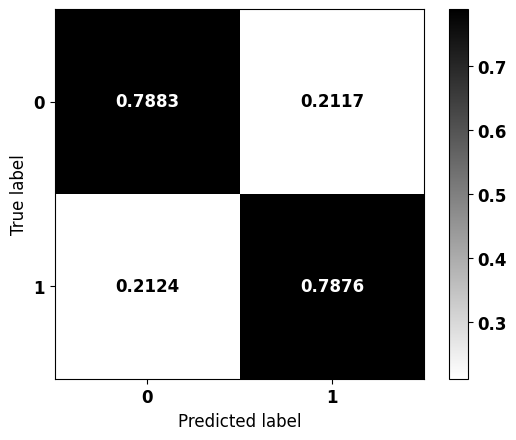


              precision    recall  f1-score   support

           0     0.8183    0.7883    0.8030     11412
           1     0.7540    0.7876    0.7704      9402

    accuracy                         0.7880     20814
   macro avg     0.7862    0.7879    0.7867     20814
weighted avg     0.7893    0.7880    0.7883     20814



In [ ]:
params = best.get_params()

# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

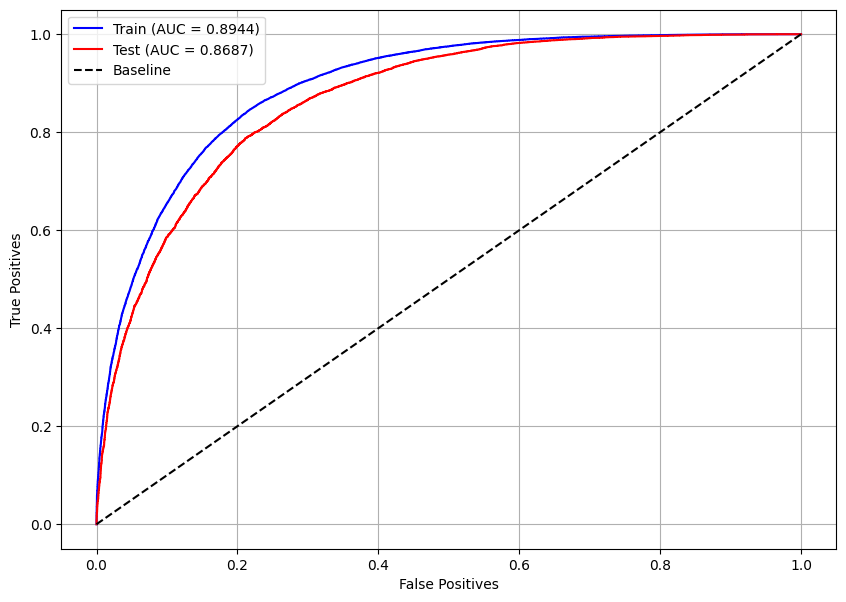

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

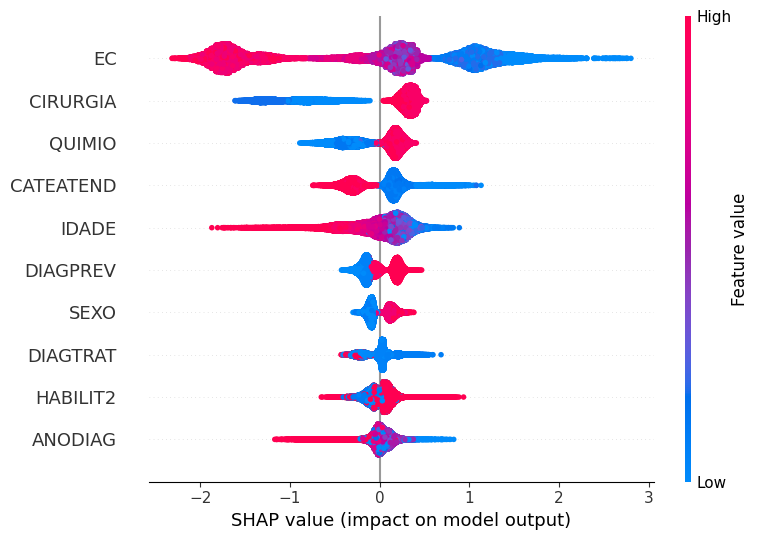

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

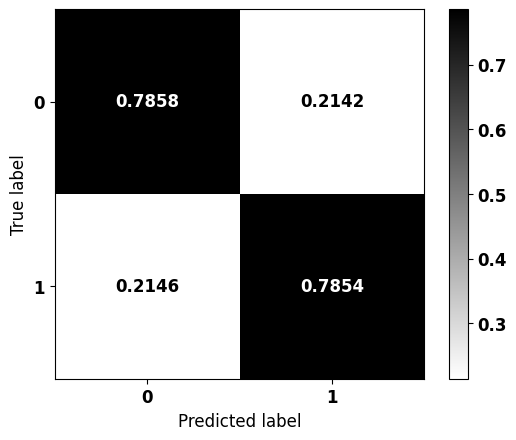


              precision    recall  f1-score   support

           0     0.8163    0.7858    0.8007     11412
           1     0.7512    0.7854    0.7679      9402

    accuracy                         0.7856     20814
   macro avg     0.7838    0.7856    0.7843     20814
weighted avg     0.7869    0.7856    0.7859     20814



In [ ]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:1.02, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

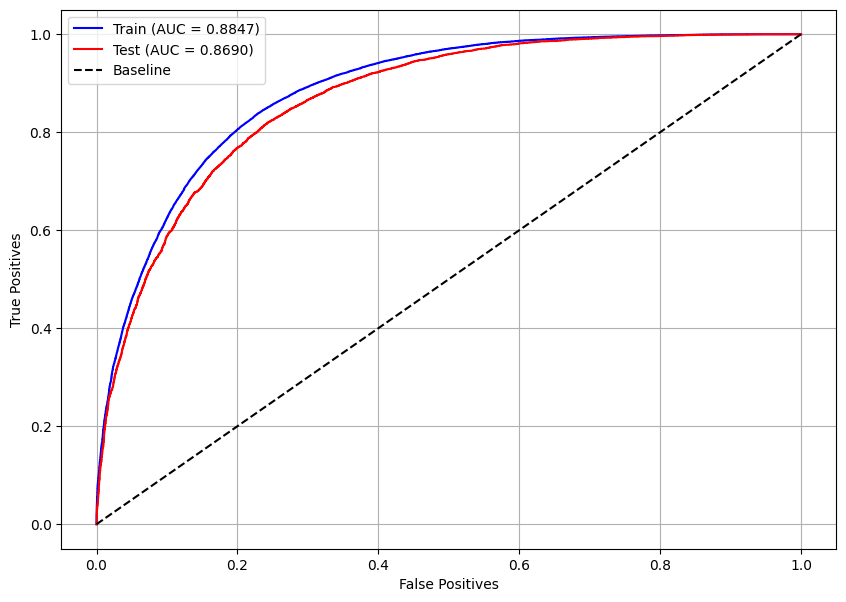

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


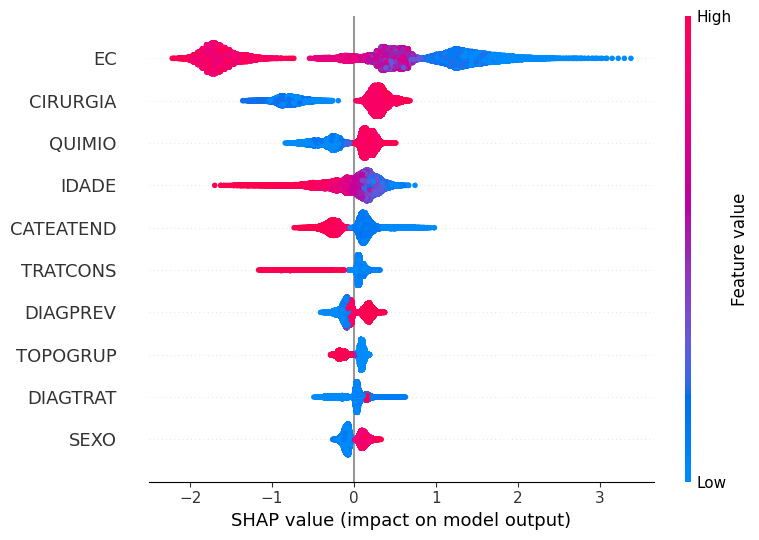

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 146,
 'max_depth': 10,
 'learning_rate': 0.12000000000000001,
 'min_child_weight': 6,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(1, 1.04, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

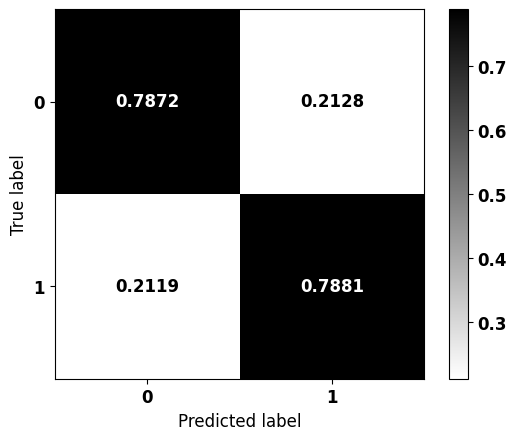


              precision    recall  f1-score   support

           0     0.8185    0.7872    0.8026     11412
           1     0.7532    0.7881    0.7703      9402

    accuracy                         0.7876     20814
   macro avg     0.7859    0.7877    0.7864     20814
weighted avg     0.7890    0.7876    0.7880     20814



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.0147, 1:1}

lgbm_random = LGBMClassifier(verbose=-1)
lgbm_random.set_params(**params)

lgbm_random.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_random, X_test, y_test)

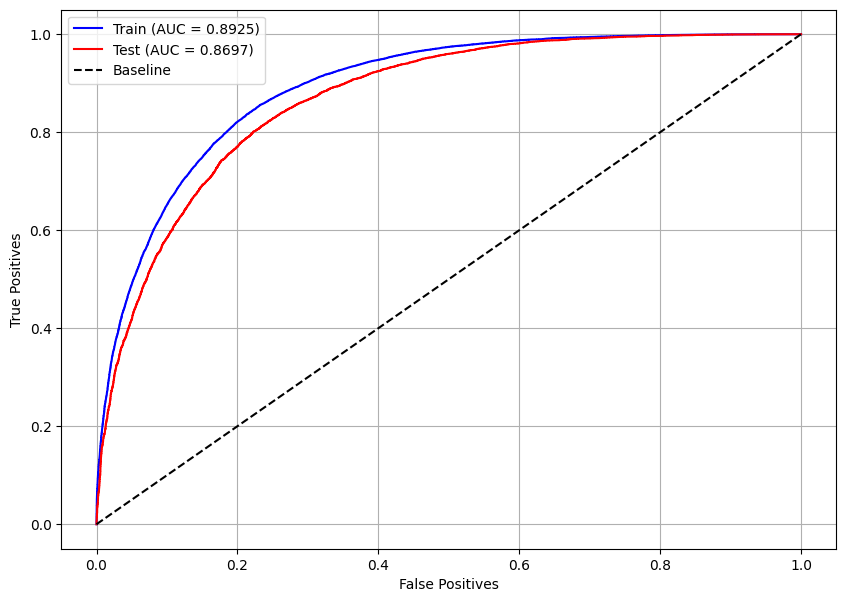

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_random, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 144,
 'max_depth': 8,
 'learning_rate': 0.13,
 'min_child_weight': 5,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(1, 1.04, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

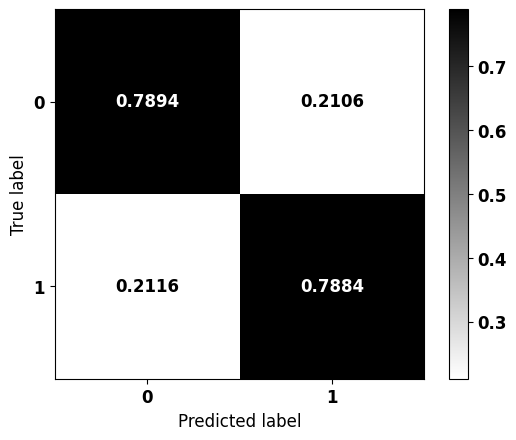


              precision    recall  f1-score   support

           0     0.8191    0.7894    0.8040     11412
           1     0.7552    0.7884    0.7715      9402

    accuracy                         0.7890     20814
   macro avg     0.7872    0.7889    0.7877     20814
weighted avg     0.7903    0.7890    0.7893     20814



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.0159, 1:1}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

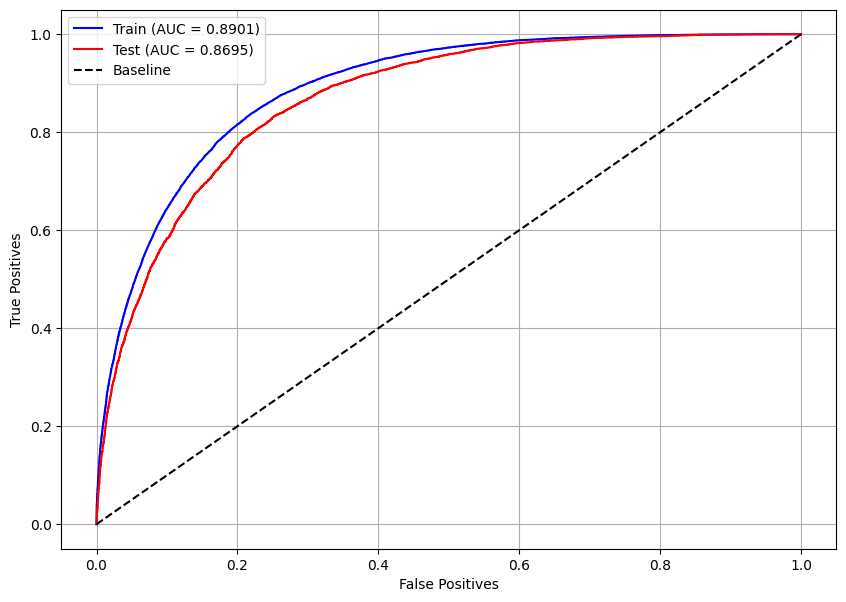

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 139,
 'max_depth': 8,
 'learning_rate': 0.15000000000000002,
 'min_child_weight': 7,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(1, 1.04, 0.0001), 4)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

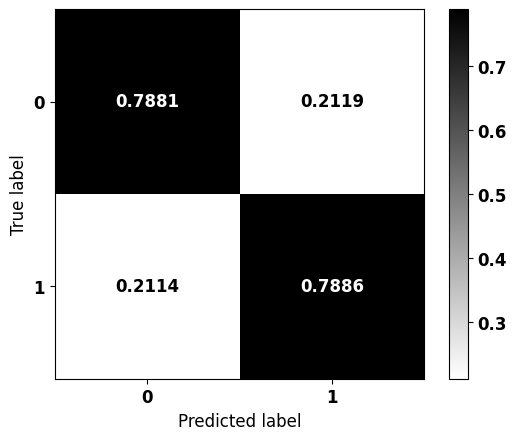


              precision    recall  f1-score   support

           0     0.8190    0.7881    0.8033     11412
           1     0.7541    0.7886    0.7709      9402

    accuracy                         0.7883     20814
   macro avg     0.7865    0.7883    0.7871     20814
weighted avg     0.7897    0.7883    0.7886     20814



In [ ]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:1.0113, 1:1}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

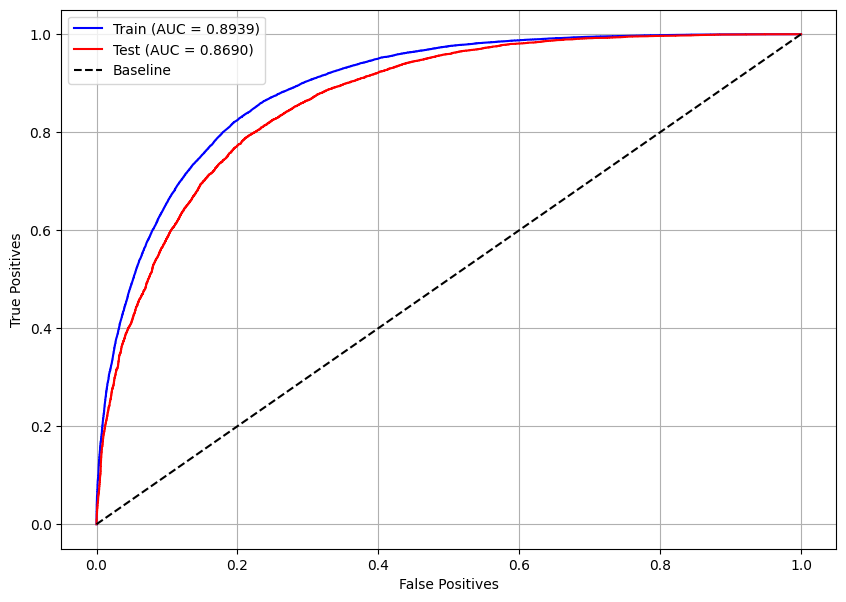

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [ ]:
# Melhor modelo
models = [lgbm_random, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1.0159, 1: 1}, colsample_bytree=0.4,
               learning_rate=0.13, max_depth=8, min_child_weight=5,
               n_estimators=144, random_state=7, verbose=-1)


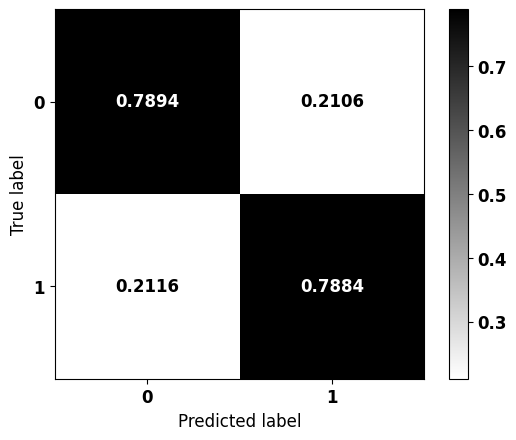


              precision    recall  f1-score   support

           0     0.8191    0.7894    0.8040     11412
           1     0.7552    0.7884    0.7715      9402

    accuracy                         0.7890     20814
   macro avg     0.7872    0.7889    0.7877     20814
weighted avg     0.7903    0.7890    0.7893     20814



In [ ]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

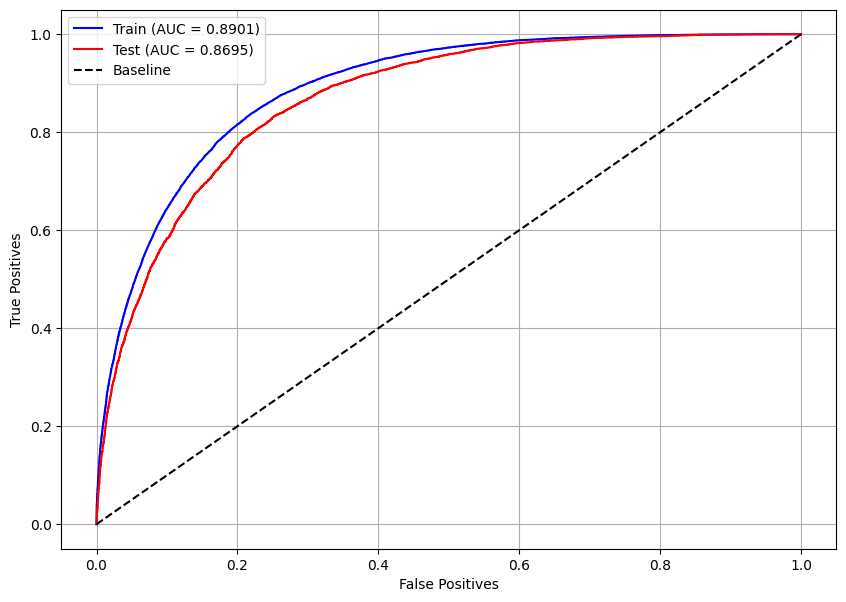

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


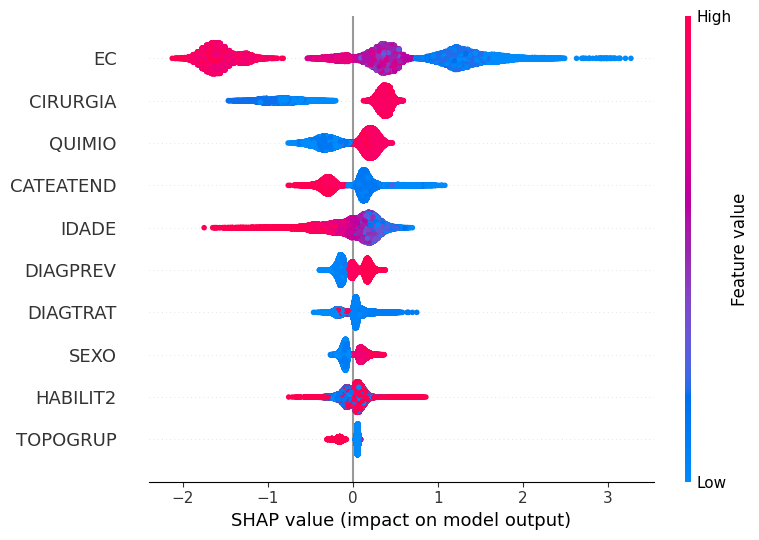

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

### **Testes cruzados**

In [ ]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 1.0159, 1: 1}, colsample_bytree=0.4,
               learning_rate=0.13, max_depth=8, min_child_weight=5,
               n_estimators=144, random_state=7, verbose=-1)


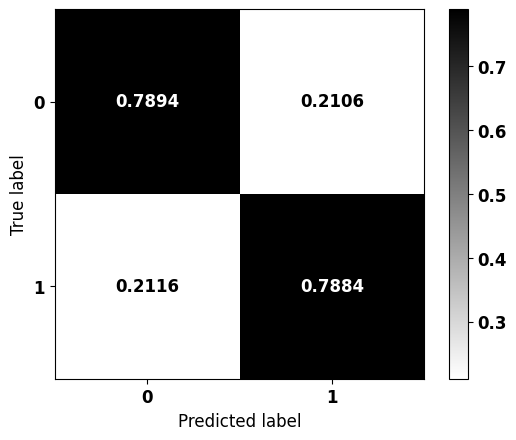


              precision    recall  f1-score   support

           0     0.8191    0.7894    0.8040     11412
           1     0.7552    0.7884    0.7715      9402

    accuracy                         0.7890     20814
   macro avg     0.7872    0.7889    0.7877     20814
weighted avg     0.7903    0.7890    0.7893     20814



In [ ]:
plot_confusion_matrix(best, X_test, y_test)

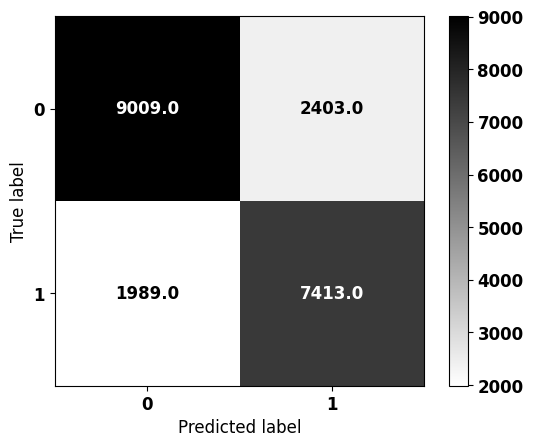


              precision    recall  f1-score   support

           0     0.8191    0.7894    0.8040     11412
           1     0.7552    0.7884    0.7715      9402

    accuracy                         0.7890     20814
   macro avg     0.7872    0.7889    0.7877     20814
weighted avg     0.7903    0.7890    0.7893     20814



In [ ]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

In [ ]:
dfs = [colo_teste, delg_teste, esto_teste]

for i, df in enumerate(dfs):
    df.TOPOGRUP.replace(df.TOPOGRUP.unique()[0], i, inplace=True)
    df['TOPOGRUP'] = ss.transform(df[['TOPOGRUP']])

In [ ]:
# Estômago
X_test_esto = esto_teste.drop(columns=list_drop).copy()
y_test_esto = esto_teste.sobrevida_3anos.copy()

# Intestino Delgado
X_test_delg = delg_teste.drop(columns=list_drop).copy()
y_test_delg = delg_teste.sobrevida_3anos.copy()

# Colorretal
X_test_colo = colo_teste.drop(columns=list_drop).copy()
y_test_colo = colo_teste.sobrevida_3anos.copy()

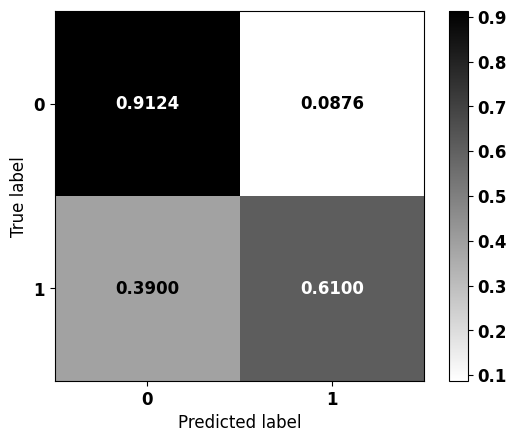


              precision    recall  f1-score   support

           0     0.8655    0.9124    0.8883      5014
           1     0.7170    0.6100    0.6592      1823

    accuracy                         0.8318      6837
   macro avg     0.7912    0.7612    0.7738      6837
weighted avg     0.8259    0.8318    0.8272      6837



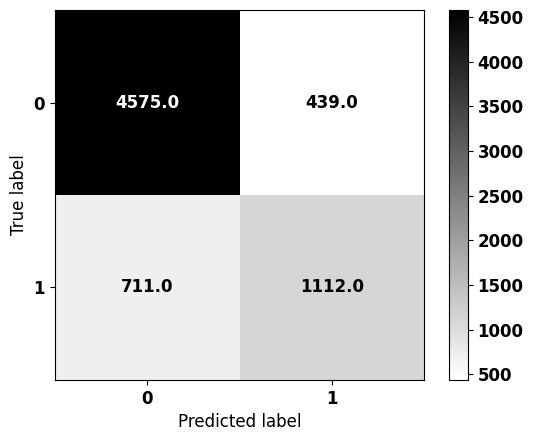


              precision    recall  f1-score   support

           0     0.8655    0.9124    0.8883      5014
           1     0.7170    0.6100    0.6592      1823

    accuracy                         0.8318      6837
   macro avg     0.7912    0.7612    0.7738      6837
weighted avg     0.8259    0.8318    0.8272      6837



In [ ]:
# Estômago
plot_confusion_matrix(best, X_test_esto, y_test_esto)
plot_confusion_matrix(best, X_test_esto, y_test_esto, norm=False)

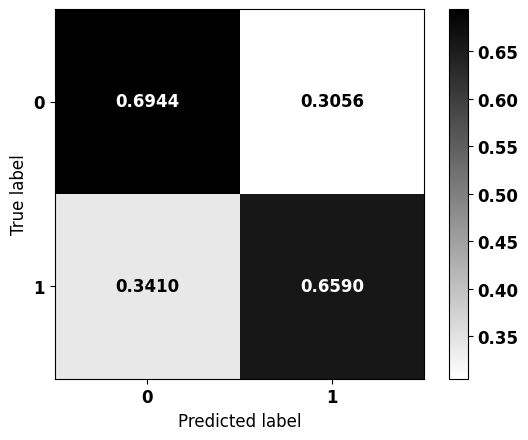


              precision    recall  f1-score   support

           0     0.7177    0.6944    0.7059       216
           1     0.6333    0.6590    0.6459       173

    accuracy                         0.6787       389
   macro avg     0.6755    0.6767    0.6759       389
weighted avg     0.6802    0.6787    0.6792       389



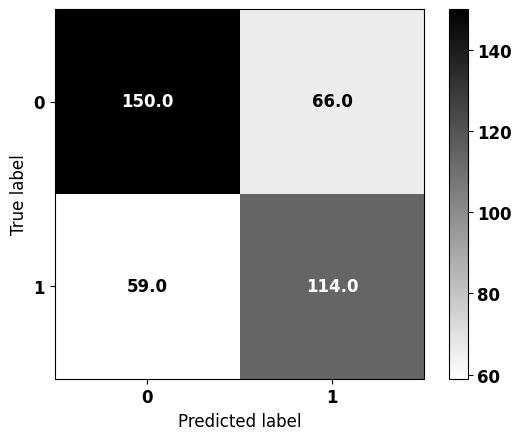


              precision    recall  f1-score   support

           0     0.7177    0.6944    0.7059       216
           1     0.6333    0.6590    0.6459       173

    accuracy                         0.6787       389
   macro avg     0.6755    0.6767    0.6759       389
weighted avg     0.6802    0.6787    0.6792       389



In [ ]:
# Intestino Delgado
plot_confusion_matrix(best, X_test_delg, y_test_delg)
plot_confusion_matrix(best, X_test_delg, y_test_delg, norm=False)

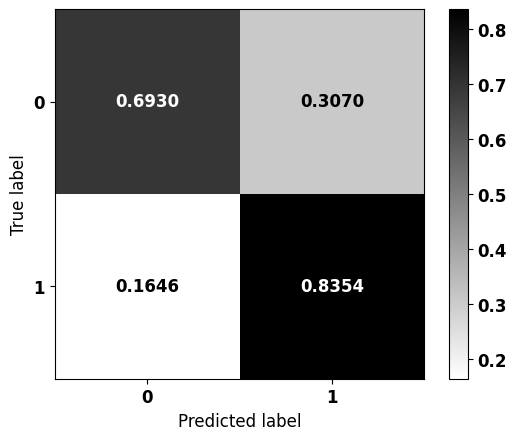


              precision    recall  f1-score   support

           0     0.7785    0.6930    0.7332      6182
           1     0.7652    0.8354    0.7988      7406

    accuracy                         0.7706     13588
   macro avg     0.7719    0.7642    0.7660     13588
weighted avg     0.7713    0.7706    0.7690     13588



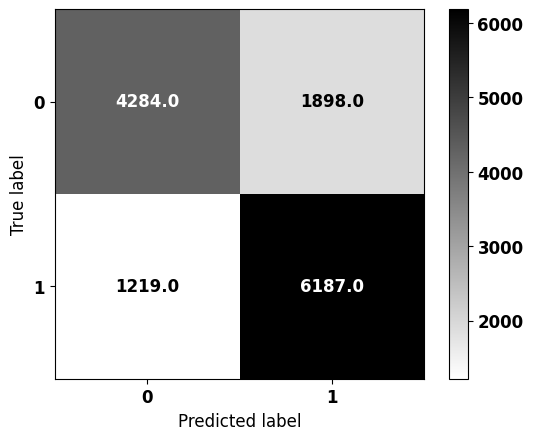


              precision    recall  f1-score   support

           0     0.7785    0.6930    0.7332      6182
           1     0.7652    0.8354    0.7988      7406

    accuracy                         0.7706     13588
   macro avg     0.7719    0.7642    0.7660     13588
weighted avg     0.7713    0.7706    0.7690     13588



In [ ]:
# Colorretal
plot_confusion_matrix(best, X_test_colo, y_test_colo)
plot_confusion_matrix(best, X_test_colo, y_test_colo, norm=False)

### **Voting Classifier**


In [ ]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7836, Optuna = 0.7880

Otimizado venceu


In [ ]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7856, Optuna = 0.7890

Otimizado venceu


In [ ]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 1.0159, 1: 1}, colsample_bytree=0.4,
               learning_rate=0.13, max_depth=8, min_child_weight=5,
               n_estimators=144, random_state=7, verbose=-1)

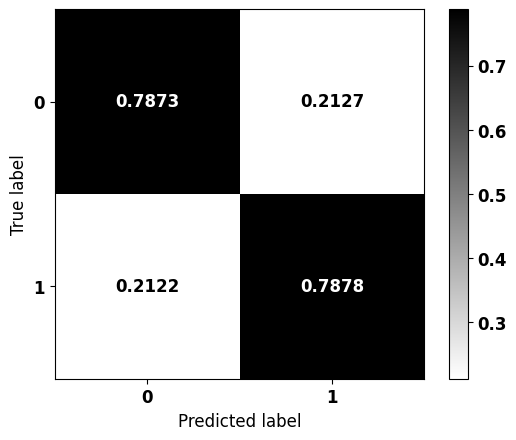


              precision    recall  f1-score   support

           0     0.8183    0.7873    0.8025     11412
           1     0.7532    0.7878    0.7701      9402

    accuracy                         0.7875     20814
   macro avg     0.7858    0.7876    0.7863     20814
weighted avg     0.7889    0.7875    0.7879     20814



In [ ]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

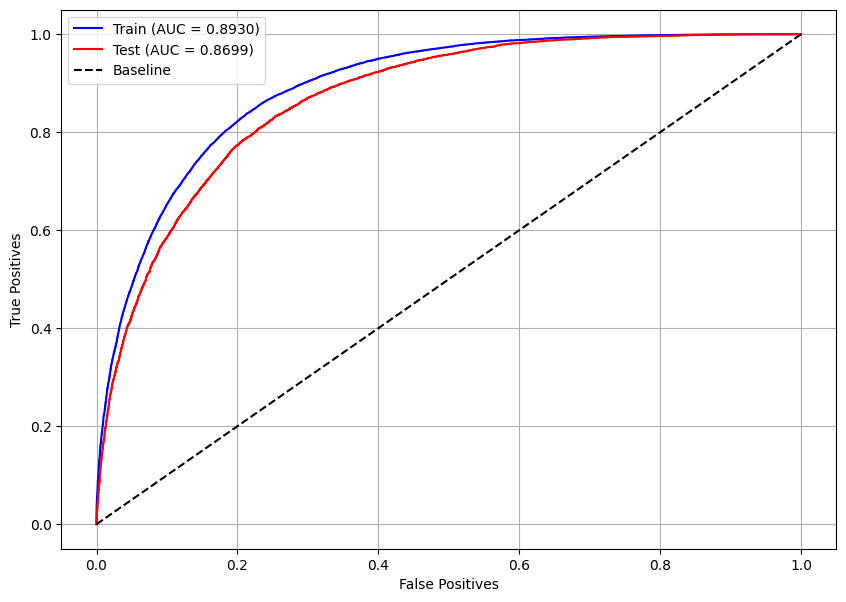

In [ ]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)